# Modeling Rule Generation

Modeling with entropy based rule generation in decision tree data structure.

In [1]:
from pathlib import Path
import sys
import os

repo_root = Path.cwd().parent.resolve() 
sys.path.insert(0, str(repo_root))

In [2]:
DATA_PATH = "../ews/data/dataset/processed_draft_1_cp_4.csv"
SEQUENCE_PATH = "../ews/data/dataset/sequence_mining_output.csv"
OUTPUT_DIR = "../ews/daa/ews_artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
from ews.rule_generation.modeling_prep import prepare_all_disasters_dataset

X, y = prepare_all_disasters_dataset(data_path=DATA_PATH, sequence_path=SEQUENCE_PATH, drop_columns=["boat_type", "role"], agg_method='sum')

y = y.replace({"low": "moderate"})

X.head()

Detected disaster types: ['Cr', 'Ts', 'Wn', 'Wv']

✅ Combined dataset ready (sum-aggregated): 247 samples, 76 features.


,fisherman_age,fisherman_experience_years,province,life_threatening_disaster_count,how_often_used_signs,how_long_used_signs_years,has_Wn-3_Wn-8,has_Wn-3_Wn-8_Wn-9,has_Wn-3_Wn-8_Wn-11,has_Wn-3_Wn-9,...,has_Wn-2_Wn-14,has_Wn-5_Wn-8,has_Ts-6_Ts-7,has_Wn-12_Wn-16,has_Wn-12_Wn-15,has_Wn-13_Wn-16,num_matched_rules,pattern_intensity,pattern_ratio,weighted_sum_norm
0,23,3,Aceh,2,3.5,3,0,0,0,0,...,0,0,0,0,0,0,0,Low,0.000000,0.000000
1,40,10,Aceh,2,18.0,10,0,0,0,0,...,0,0,0,0,0,0,4,Medium,6.257143,0.682431
2,52,25,Aceh,5,18.0,25,0,0,0,0,...,0,0,0,0,0,0,6,High,9.385714,1.000000
3,52,25,Aceh,8,18.0,22,0,0,0,0,...,0,0,0,0,0,0,0,Low,0.000000,0.000000
4,49,26,Aceh,1,30.0,22,0,0,0,0,...,0,0,0,0,0,0,11,High,17.207143,1.000000


SPM cols: 66, context cols: 13

=== Base Model Performance ===
              precision    recall  f1-score  support
high           0.714286  0.689655  0.701754    29.00
moderate       0.590909  0.619048  0.604651    21.00
accuracy       0.660000  0.660000  0.660000     0.66
macro avg      0.652597  0.654351  0.653203    50.00
weighted avg   0.662468  0.660000  0.660971    50.00
Confusion matrix:
 [[20  9]
 [ 8 13]]

Best Parameters: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

=== Tuned Model Performance ===
              precision    recall  f1-score  support
high           0.750000  0.827586  0.786885    29.00
moderate       0.722222  0.619048  0.666667    21.00
accuracy       0.740000  0.740000  0.740000     0.74
macro avg      0.736111  0.723317  0.726776    50.00
weighted avg   0.738333  0.740000  0.736393    50.00
Confusion matrix:
 [[24  5]
 [ 8 13]]


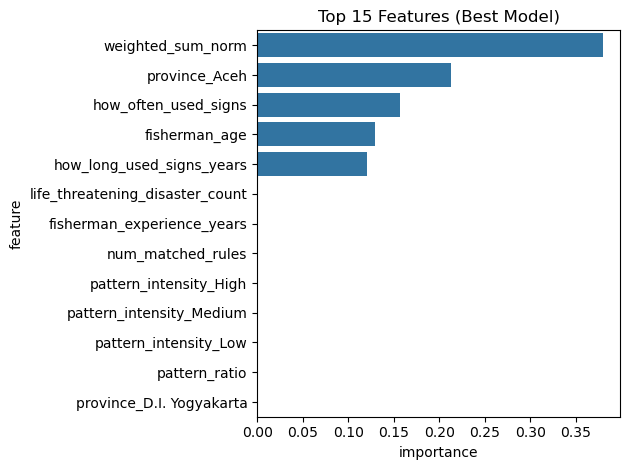


=== Decision Tree Rules (Best Model) ===
|--- weighted_sum_norm <= 0.18
|   |--- province_Aceh <= 0.50
|   |   |--- class: moderate
|   |--- province_Aceh >  0.50
|   |   |--- how_long_used_signs_years <= 11.50
|   |   |   |--- fisherman_age <= 25.50
|   |   |   |   |--- class: high
|   |   |   |--- fisherman_age >  25.50
|   |   |   |   |--- how_often_used_signs <= 3.25
|   |   |   |   |   |--- class: high
|   |   |   |   |--- how_often_used_signs >  3.25
|   |   |   |   |   |--- class: moderate
|   |   |--- how_long_used_signs_years >  11.50
|   |   |   |--- class: high
|--- weighted_sum_norm >  0.18
|   |--- class: high



In [4]:
from ews.rule_generation.model_fit import fit_hybrid_model

params_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 7, 9],
    "min_samples_leaf": [2, 3, 4, 5],
    "min_samples_split": [2, 4, 6],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01, 0.02] 
}

result = fit_hybrid_model(
    X, y,
    params_grid=params_grid,
    cv_splits=5,
    plot=True,
    random_state=42
)

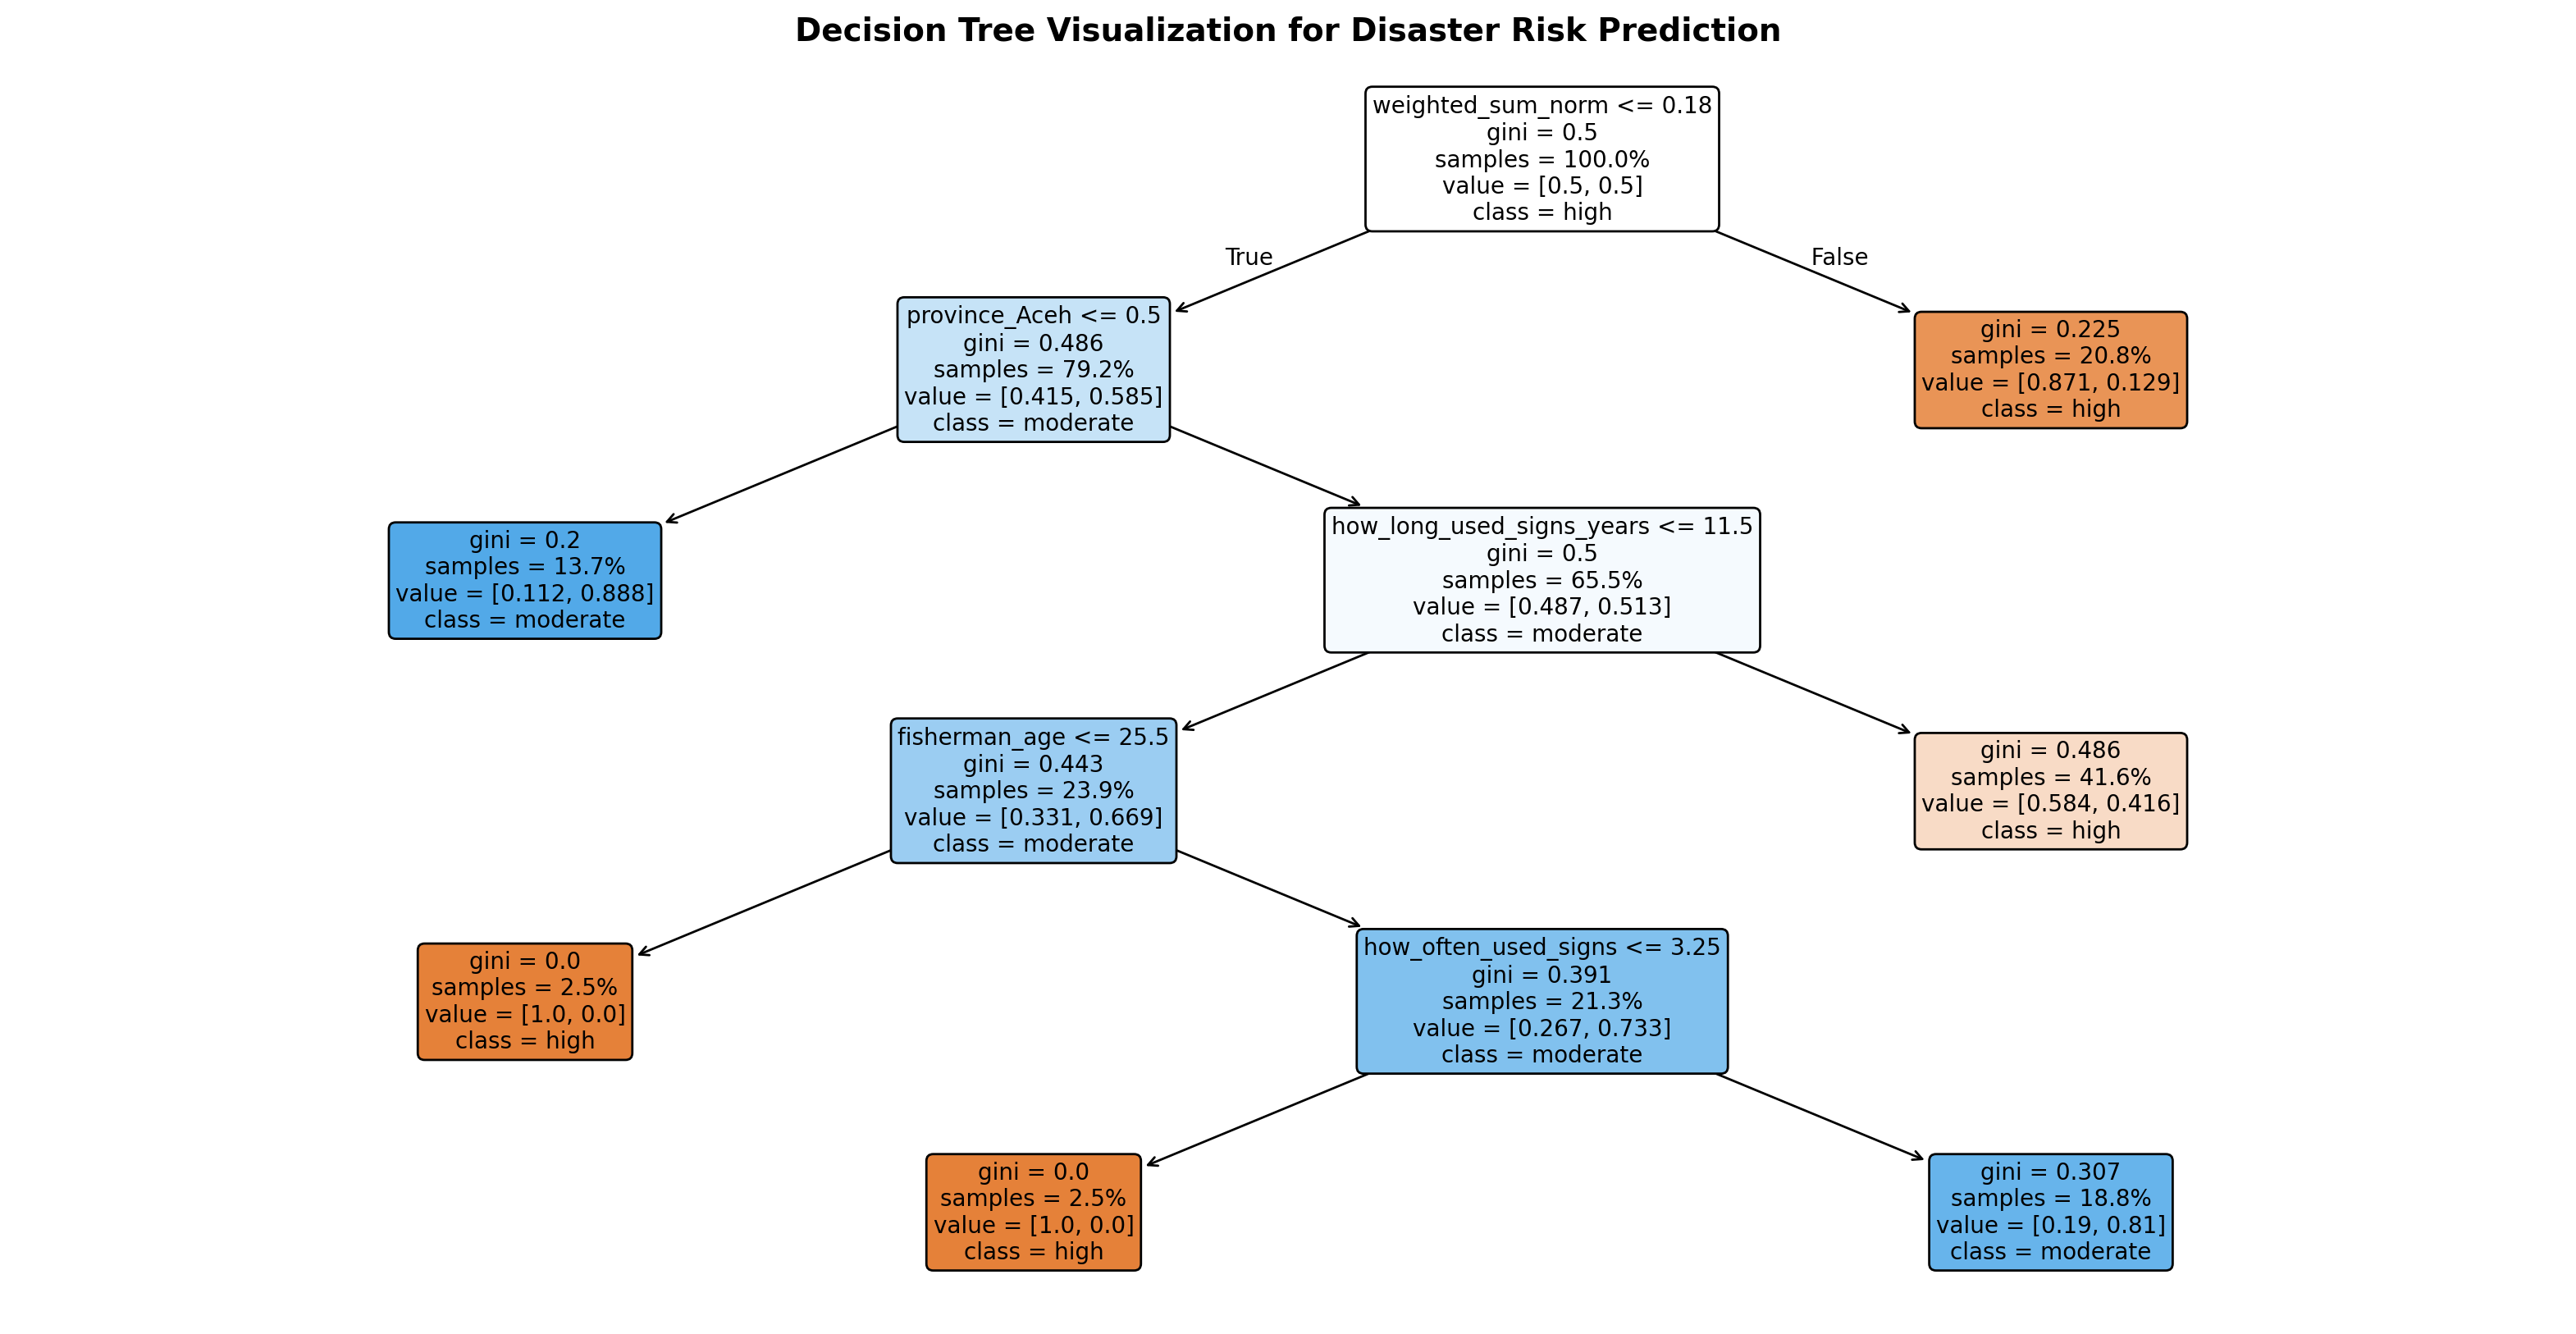

In [5]:
from ews.rule_generation.rule_representation import visualize_decision_tree_graph

best_model = result["best_model"]

feature_names = best_model.feature_names_in_.tolist()

visualize_decision_tree_graph(best_model, feature_names)

# Implementing Fuzzy Logic to Decision Tree

In [6]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

Preparing the dataset

In [7]:
X_fuzz = X.copy()

retain_cols = [c for c in X_fuzz.columns if not c.startswith('has_')]
X_fuzz = X_fuzz[retain_cols]

X_fuzz.head()

,fisherman_age,fisherman_experience_years,province,life_threatening_disaster_count,how_often_used_signs,how_long_used_signs_years,num_matched_rules,pattern_intensity,pattern_ratio,weighted_sum_norm
0,23,3,Aceh,2,3.5,3,0,Low,0.000000,0.000000
1,40,10,Aceh,2,18.0,10,4,Medium,6.257143,0.682431
2,52,25,Aceh,5,18.0,25,6,High,9.385714,1.000000
3,52,25,Aceh,8,18.0,22,0,Low,0.000000,0.000000
4,49,26,Aceh,1,30.0,22,11,High,17.207143,1.000000


In [8]:
def generate_fuzzy_params(df, feature_name, threshold, k=0.4, clip_to_minmax=True):
    data = df[feature_name]
    sigma = data.std()

    if sigma == 0:
        sigma = 0.001

    delta = k * sigma

    slope_start = threshold - delta
    slope_end = threshold + delta

    if clip_to_minmax:
        min_val = data.min()
        max_val = data.max()

        slope_start = max(min_val, slope_start)
        slope_end = min(max_val, slope_end)

    return {
        'slope_start': round(slope_start, 4),
        'slope_end': round(slope_end, 4),
        'std_dev': round(sigma, 4)
    }

In [27]:
pattern_params = generate_fuzzy_params(X_fuzz, 'weighted_sum_norm', 0.18)
how_long_params = generate_fuzzy_params(X_fuzz, 'how_long_used_signs_years', 11.50)
fisherman_age_params = generate_fuzzy_params(X_fuzz, 'fisherman_age', 25.50)
how_often_used_signs_params = generate_fuzzy_params(X_fuzz, 'how_often_used_signs', 3.25)

print("Pattern Params:", pattern_params)
print("How Long Used Signs Params:", how_long_params)
print("Fisherman Age Params:", fisherman_age_params)
print("How Often Used Signs Params:", how_often_used_signs_params)

Pattern Params: {'slope_start': np.float64(0.0495), 'slope_end': np.float64(0.3105), 'std_dev': np.float64(0.3262)}
How Long Used Signs Params: {'slope_start': np.float64(8.1961), 'slope_end': np.float64(14.8039), 'std_dev': np.float64(8.2597)}
Fisherman Age Params: {'slope_start': np.float64(21.7364), 'slope_end': np.float64(29.2636), 'std_dev': np.float64(9.4091)}
How Often Used Signs Params: {'slope_start': np.float64(1.0), 'slope_end': np.float64(6.5743), 'std_dev': np.float64(8.3109)}


In [10]:
# --- 1. Define Robust Universes of Discourse (UoD) ---
u_pattern_score = np.arange(0, 1.01, 0.01)
u_province = np.arange(0, 2, 1)  
u_how_long = np.arange(0, 51, 1)  
u_age = np.arange(15, 76, 1)  
u_how_often = np.arange(0, 31, 1) 
u_risk = np.arange(0, 1.01, 0.01)

# --- 2. Create Antecedent (Input) and Consequent (Output) Variables ---
pattern_score = ctrl.Antecedent(u_pattern_score, 'pattern_match_score')
province_Aceh = ctrl.Antecedent(u_province, 'province_aceh')
how_long_used_signs_years = ctrl.Antecedent(u_how_long, 'how_long_used_signs_years')
fisherman_age = ctrl.Antecedent(u_age, 'fisherman_age')
how_often_used_signs = ctrl.Antecedent(u_how_often, 'how_often_used_signs')

risk = ctrl.Consequent(u_risk, 'risk')

# --- 3. Define Fuzzy Membership Functions (MFs) ---
pattern_score['Low'] = fuzz.trapmf(u_pattern_score, [0, 0, pattern_params['slope_start'], pattern_params['slope_end']])
pattern_score['High'] = fuzz.trapmf(u_pattern_score, [pattern_params['slope_start'], pattern_params['slope_end'], 1, 1])

province_Aceh['Not_Aceh'] = fuzz.trimf(u_province, [0, 0, 0.1])
province_Aceh['Is_Aceh'] = fuzz.trimf(u_province, [0.9, 1, 1])

how_long_used_signs_years['Short_Time'] = fuzz.trapmf(u_how_long, [0, 0, how_long_params['slope_start'], how_long_params['slope_end']])
how_long_used_signs_years['Long_Time'] = fuzz.trapmf(u_how_long, [how_long_params['slope_start'], how_long_params['slope_end'], 50, 50])

fisherman_age['Young'] = fuzz.trapmf(u_age, [15, 15, fisherman_age_params['slope_start'], fisherman_age_params['slope_end']])
fisherman_age['Mature'] = fuzz.trapmf(u_age, [fisherman_age_params['slope_start'], fisherman_age_params['slope_end'], 75, 75])

how_often_used_signs['Infrequent'] = fuzz.trapmf(u_how_often, [0, 0, how_often_used_signs_params['slope_start'], how_often_used_signs_params['slope_end']])
how_often_used_signs['Frequent'] = fuzz.trapmf(u_how_often, [how_often_used_signs_params['slope_start'], how_often_used_signs_params['slope_end'], 30, 30])

# MFs for 'risk' (Output)
risk['Moderate'] = fuzz.trimf(u_risk, [0, 0, 1])
risk['High'] = fuzz.trimf(u_risk, [0, 1, 1])

print("Fuzzy variables and membership functions defined successfully.")

Fuzzy variables and membership functions defined successfully.


Visualizing Membership Functions...


c:\Users\anakingfl\anaconda3\envs\mlenv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


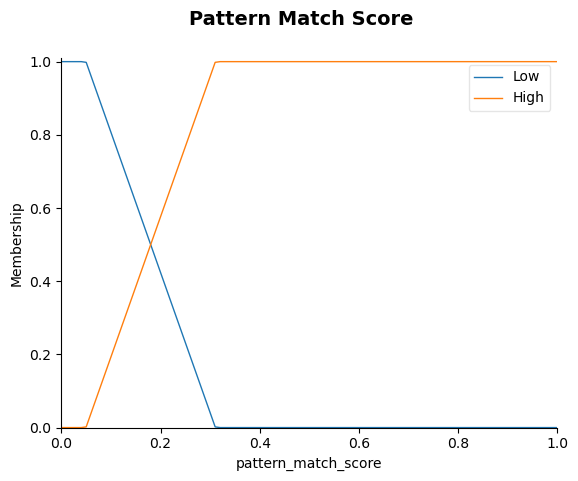

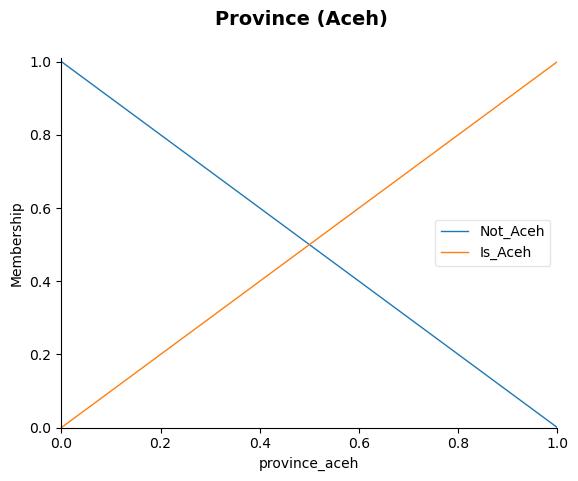

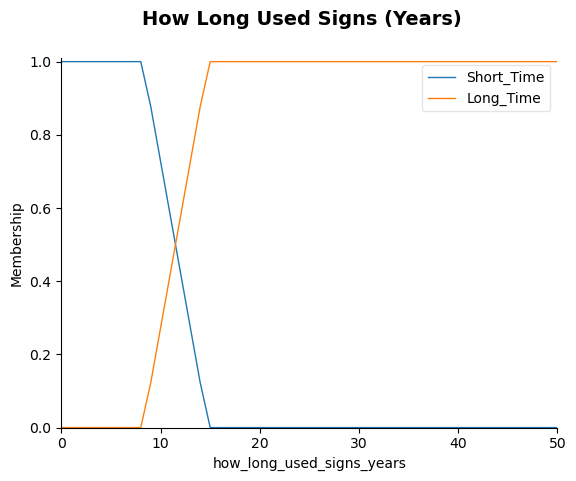

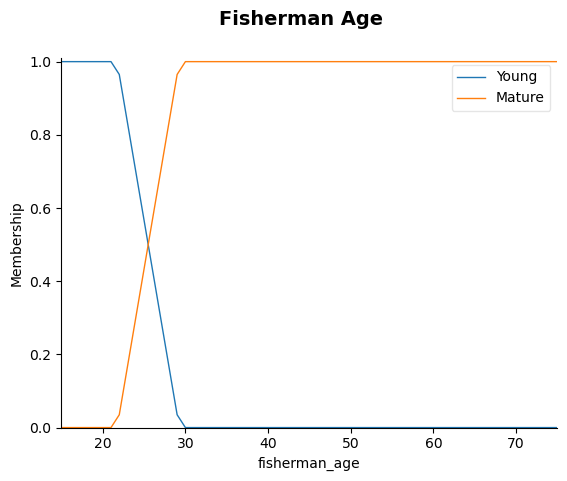

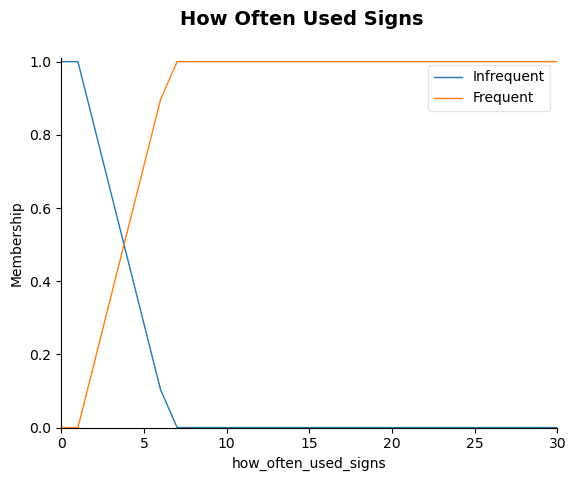

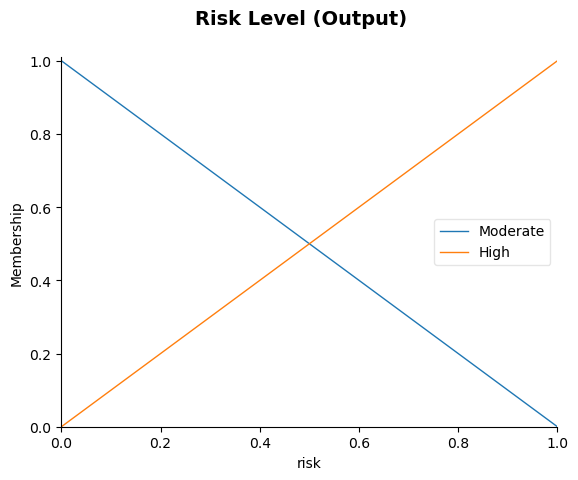

Fuzzy membership functions visualization complete!


In [11]:
print("Visualizing Membership Functions...")

pattern_score.view()
plt.suptitle('Pattern Match Score', fontsize=14, fontweight='bold')
plt.show()

province_Aceh.view()
plt.suptitle('Province (Aceh)', fontsize=14, fontweight='bold')
plt.show()

how_long_used_signs_years.view()
plt.suptitle('How Long Used Signs (Years)', fontsize=14, fontweight='bold')
plt.show()

fisherman_age.view()
plt.suptitle('Fisherman Age', fontsize=14, fontweight='bold')
plt.show()

how_often_used_signs.view()
plt.suptitle('How Often Used Signs', fontsize=14, fontweight='bold')
plt.show()

risk.view()
plt.suptitle('Risk Level (Output)', fontsize=14, fontweight='bold')
plt.show()

print("Fuzzy membership functions visualization complete!")

In [12]:
rule1 = ctrl.Rule(pattern_score['Low'] & province_Aceh['Not_Aceh'],
                  risk['Moderate'])

rule2 = ctrl.Rule(pattern_score['Low'] & province_Aceh['Is_Aceh'] &
                  how_long_used_signs_years['Short_Time'] & fisherman_age['Young'],
                  risk['High'])

rule3 = ctrl.Rule(pattern_score['Low'] & province_Aceh['Is_Aceh'] &
                  how_long_used_signs_years['Short_Time'] & fisherman_age['Mature'] &
                  how_often_used_signs['Infrequent'],
                  risk['High'])

rule4 = ctrl.Rule(pattern_score['Low'] & province_Aceh['Is_Aceh'] &
                  how_long_used_signs_years['Short_Time'] & fisherman_age['Mature'] &
                  how_often_used_signs['Frequent'],
                  risk['Moderate'])

rule5 = ctrl.Rule(pattern_score['Low'] & province_Aceh['Is_Aceh'] &
                  how_long_used_signs_years['Long_Time'],
                  risk['High'])

rule6 = ctrl.Rule(pattern_score['High'],
                  risk['High'])

print("Fuzzy rules created successfully.")

risk_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

print("Fuzzy Inference System (FIS) is built and ready for simulation.")

Fuzzy rules created successfully.
Fuzzy Inference System (FIS) is built and ready for simulation.


Preprocessing the data for inference testing

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Encode y labels to 1 and 0
y_encoded = y.replace({"moderate": 0, "high": 1})

# Encode Aceh
X_fuzz['province'] = X_fuzz['province'].apply(lambda x: 1 if x == 'Aceh' else 0)

C:\Users\anakingfl\AppData\Local\Temp\ipykernel_19928\1458398795.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_encoded = y.replace({"moderate": 0, "high": 1})


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_fuzz, y_encoded, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_test.head()

,fisherman_age,fisherman_experience_years,province,life_threatening_disaster_count,how_often_used_signs,how_long_used_signs_years,num_matched_rules,pattern_intensity,pattern_ratio,weighted_sum_norm
96,29,8,1,4,3.5,8,0,Low,0.000000,0.000000
46,40,11,1,1,30.0,11,5,High,7.821429,0.454545
166,39,19,1,2,18.0,19,4,Medium,6.257143,0.720657
54,30,10,1,4,3.5,10,1,Low,1.564286,0.962165
93,47,15,1,4,3.5,15,0,Low,0.000000,0.000000


In [26]:
import pandas as pd
import numpy as np

input_data = X_test.copy()
evaluation_data = []

print(f"{'ACTUAL':<10} | {'PRED SCORE':<12} | {'INTUITION CHECK'}")
print("-" * 50)

count = 0
MIN_VAL = 1/3
MAX_VAL = 2/3
RANGE = MAX_VAL - MIN_VAL

for idx, row in input_data.iterrows():
    try:
        risk_sim.input['pattern_match_score'] = row['weighted_sum_norm']
        risk_sim.input['province_aceh'] = row['province']
        risk_sim.input['how_long_used_signs_years'] = row['how_long_used_signs_years']
        risk_sim.input['fisherman_age'] = row['fisherman_age']
        risk_sim.input['how_often_used_signs'] = row['how_often_used_signs']
        
        risk_sim.compute()
        risk_score = risk_sim.output['risk']

        scaled_score = (risk_score - MIN_VAL) / RANGE
        scaled_score = np.clip(scaled_score, 0.0, 1.0)
        
        actual_label = y_test.loc[idx] 
        actual_text = "RISKY" if actual_label == 1 else "MODERATE"

        comment = ""
        if actual_label == 1 and scaled_score > 0.8:
            comment = "Good Catch"
        elif actual_label == 0 and scaled_score < 0.6:
            comment = "Correctly Moderate"
        elif actual_label == 0 and scaled_score > 0.8:
            comment = "🟡 False Alarm"
        elif actual_label == 1 and scaled_score < 0.6:
            comment = "🔴 Missed Risk (Dangerous)"
        else:
            comment = "Ambiguous Zone"

        evaluation_data.append({
            'Actual': actual_text,
            'Risk_Score': scaled_score,
            'Comment': comment
        })

        if count < 50:
            print(f"{actual_text:<10} | {scaled_score:.4f}       | {comment}")
            count += 1

    except Exception as e:
        print(f"Error at index {idx}: {e}")

eval_df = pd.DataFrame(evaluation_data)

ACTUAL     | PRED SCORE   | INTUITION CHECK
--------------------------------------------------
MODERATE   | 0.5770       | Correctly Moderate
RISKY      | 1.0000       | Good Catch
RISKY      | 1.0000       | Good Catch
RISKY      | 1.0000       | Good Catch
RISKY      | 1.0000       | Good Catch
MODERATE   | 1.0000       | 🟡 False Alarm
MODERATE   | 0.5770       | Correctly Moderate
RISKY      | 0.9964       | Good Catch
MODERATE   | 1.0000       | 🟡 False Alarm
RISKY      | 1.0000       | Good Catch
RISKY      | 1.0000       | Good Catch
RISKY      | 0.0036       | 🔴 Missed Risk (Dangerous)
MODERATE   | 1.0000       | 🟡 False Alarm
RISKY      | 1.0000       | Good Catch
MODERATE   | 1.0000       | 🟡 False Alarm
RISKY      | 1.0000       | Good Catch
RISKY      | 0.9592       | Good Catch
RISKY      | 1.0000       | Good Catch
RISKY      | 1.0000       | Good Catch
RISKY      | 1.0000       | Good Catch
MODERATE   | 0.5990       | Correctly Moderate
MODERATE   | 0.5770       | Correct